In [1]:
%pylab inline

%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


# Experiments Dense vs GCN

We want to run a set of controlled experiments in which a Dense network and a GCN are learning various graph moments:

1. Degree: 
    1. Dense: Show dependence of Loss MAE for learning degree on 
        1. network size
        2. size of training set

In [2]:
from sklearn.metrics import r2_score

import tensorflow as tf
sess = tf.InteractiveSession()

from keras.backend import set_session
set_session(sess)

Using TensorFlow backend.


In [114]:
from keras import backend as K
from keras.layers import Layer, Input, InputSpec, Concatenate

In [16]:
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Activation, Flatten, Reshape, Multiply, Add, LSTM, LSTMCell, SimpleRNN
from keras.optimizers import Adam, RMSprop
from keras import layers

In [6]:

class EpochHistory_1(tf.keras.callbacks.Callback):
    
#     def on_train_begin(self, logs={}):
    def __init__(self, metrics=[], get_best_weights = False, verbosity = 10):
        """ metrics: 'acc' to save 'acc' and 'val_acc'; always saves 'loss', 'val_loss'
        
        """
        self.history = {k:[] for k in metrics+['loss','val_loss']}
        self.best_weights = None
        self.best_val_loss = 0
        self.get_best_weights = get_best_weights
        self.verbosity = verbosity
        super().__init__()

    def on_epoch_end(self, epoch, logs={}):
        for k in self.history:
            self.history[k].append(logs.get(k))
        if self.verbosity and (epoch % self.verbosity) ==0:
            print('Ep: %d\t' %epoch + '\t'.join(['%s: %.4g' %(k,self.history[k][-1]) for k in self.history]))
        if self.get_best_weights and self.history['val_loss'][-1] < self.best_val_loss:
            self.best_val_loss = self.history['val_loss'][-1]
            print('Validation loss improved; getting weights')
#             self.best_weights = self.model.get_weights()
#             if (epoch % 10) ==0 and epoch >1:
#                 print('saving model...')
#                 self.model.save('./graph-gen-test.h5')
                
            
        


In [8]:
import networkx as nx

def make_BA_dataset(N,n,m=2):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.barabasi_albert_graph(n=n,m=m)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj

def make_ER_dataset(N,n,p=0.1):
    adj = np.empty((N,n,n), dtype=np.float32)
    for j in range(N):
        g = nx.erdos_renyi_graph(n=n, p=p)
        a = zeros((n,n), dtype=np.float32)
        for i in g.edges:
            a[i] = 1
            a[i[::-1]] = 1
        adj[j] = a
    return adj
    

In [9]:
# X = make_BA_dataset(1000, 20)
X = make_ER_dataset(1000, 20, p = .2)

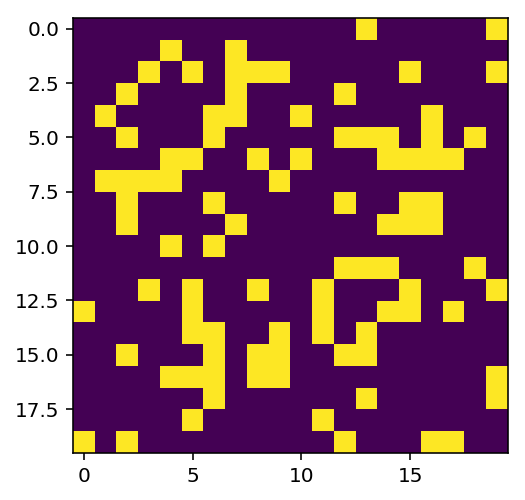

In [10]:
imshow(X[0])

## Learning Degree Using a Fully Connected (Dense) Layer

## Erdos-Renyi (ER) Model
This is a random graph, where each edge has the same probability of being present. 

## Grid search 
run for multiple hidden layer sizes and multiple dataset sizes

In [ ]:
n_nodes = 20
p = 2./n_nodes # density of edges (1=fully connected)

histories = {}

for n_samples in int0(logspace(log10(5e2), log10(1e4), 4))[::-1]:
    print ('%d Samples\n' % n_samples)
    histories[n_samples] = {}
    X = make_ER_dataset(n_samples, n_nodes, p = p)
    Y = X.sum(-1, keepdims=0)
    #for units in int0(logspace(log10(2), log10(2*n_nodes), 8)):
    #for units in int0(linspace((2), (2*n_nodes), 8)):
    for units in int0(linspace((.25*n_nodes), (1.75*n_nodes), 9)):
        print(units)
        ephist = EpochHistory_1(verbosity=50)

        model = Sequential()
        model.add(Flatten(input_shape=X[0].shape))
        model.add(Dense(units, activation='relu', ))
        model.add(Dense(n_nodes, activation='linear'))

        model.compile(loss='mse', optimizer='adam')
#         model.summary()
        
        history = model.fit(X, Y, epochs= 510, validation_split=0.2,callbacks=[ephist], verbose=0 )
        histories[n_samples][units] = history.history
        
#         for k in ['loss', 'val_loss']:
#             plot(ephist.history[k], label = k)
#         legend()
#         yscale('log')
#         xscale('log')
#         show()
        
        

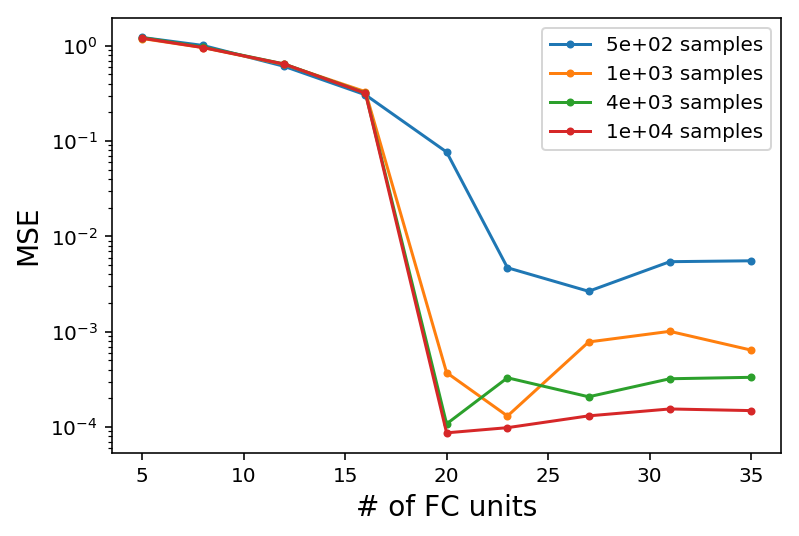

In [21]:
for num in sorted(histories)[:]:
    us, loss, val_loss = [], [],[]
    for u in sorted(histories[num]):
        us += [u]
        # find best fit
        i = argmin(histories[num][u]['val_loss'])
        loss += [histories[num][u]['loss'][i]]
        val_loss += [histories[num][u]['val_loss'][i]]
        
    #plot(us,loss)
    plot(us, val_loss,'.-', label = '%.1g samples' %num)

legend()
ylabel('MSE', size = 14)
xlabel('# of FC units', size = 14)
yscale('log')
#xscale('log')
#show()

savefig('../figs/expressivity/fc-mse-N%d-var-samples.pdf' % (n_nodes))
savefig('../figs/expressivity/fc-mse-N%d-var-samples.png' % (n_nodes), dpi = 300)

# Learning Using GCN
Below is a simple implemetation of GCN in keras. 

In [10]:
import keras
from keras import Input

In [11]:
from keras import backend as K
from keras.layers import Layer

# sess = tf.InteractiveSession()
# K.set_session(sess)

class GCN(Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        super(GCN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build:',input_shape)
        A_shape, h_shape = input_shape
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(h_shape[-1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        super(GCN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        print('call:')
        A,h = inputs
        return [A, K.dot(K.batch_dot(A,h ), self.kernel)]
        
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        A_shape, h_shape = input_shape
        return [A_shape, tuple(h_shape[:-1])+(self.kernel.shape.as_list()[-1],)]

## 1 GCN layer 
First test single layer for degree

In [ ]:
n_nodes = 20
p = 2./n_nodes # density of edges (1=fully connected)

histories = {}

for n_samples in int0(logspace(log10(5e1), log10(2e3), 6))[::-1]:
    print ('%d Samples\n' % n_samples)
    histories[n_samples] = {}
    X = make_ER_dataset(n_samples, n_nodes, p = p)
    Y = X.sum(-1, keepdims=1)
    h = ones_like(Y)
    #for units in int0(linspace((.25*n_nodes), (1.75*n_nodes), 9)):
    #    print(units)
    inputs = [Input(shape=X.shape[1:]),Input(shape= h.shape[1:]) ]

    gc = GCN(1)(inputs)
    # gc = GCN(1)(gc)

    model_GCN = Model(inputs = inputs, outputs = gc[1])

    model_GCN.compile(loss='mse', optimizer='adam')
#     model_GCN.summary()
    
    ephist_GCN = EpochHistory_1(verbosity=20)
    history = model_GCN.fit([X,h],[Y], validation_split=0.2, epochs= (2000*200)//n_samples, callbacks=[ephist_GCN], verbose=0)
    histories[n_samples] = history.history
        
#         for k in ['loss', 'val_loss']:
#             plot(ephist.history[k], label = k)
#         legend()
#         yscale('log')
#         xscale('log')
#         show()
        
        

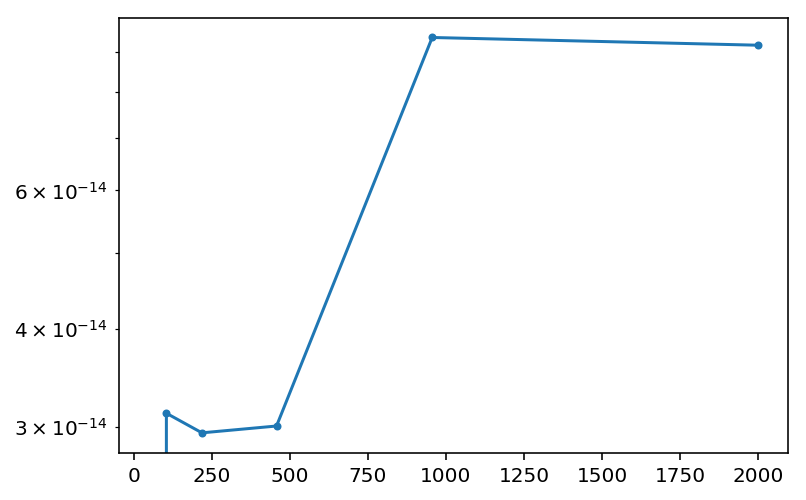

In [50]:
val = array([[k, min(histories[k]['val_loss'])] for k in sorted(histories)])

plot(*val.T, marker = '.')
yscale('log')

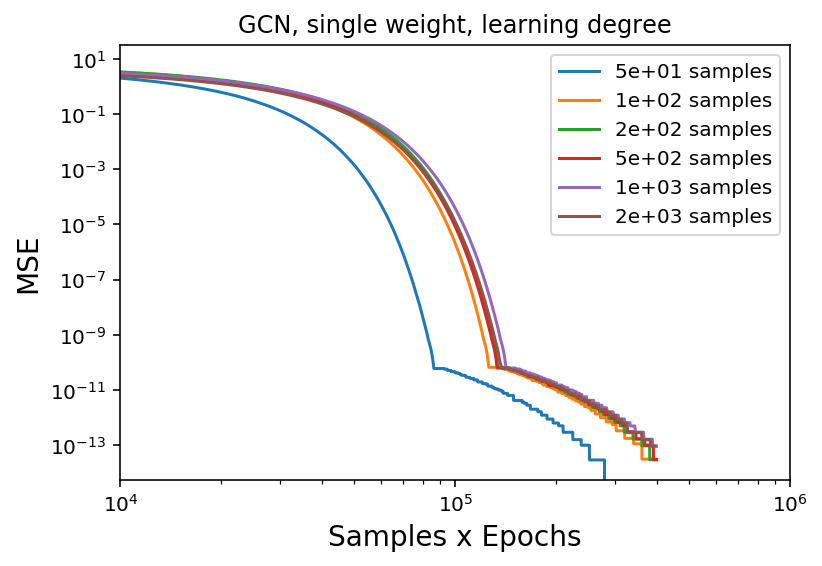

In [63]:
for k in sorted(histories):
    for s in ['val_loss']:
        y = histories[k][s]
        plot(arange(len(y))*k,y, label = '%.1g samples' %k)

title('GCN, single weight, learning degree')
legend()
yscale('log')
xscale('log')

ylabel('MSE', size = 14)
xlim(1e4,1e6)
xlabel('Samples x Epochs', size = 14)
#     show()

savefig('../figs/expressivity/gcn-1-N%d-var-samples.pdf' %(n_nodes))
savefig('../figs/expressivity/gcn-1-N%d-var-samples.png' %(n_nodes), dpi = 300)

(array([3., 0., 7., 0., 0., 4., 0., 3., 0., 3.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

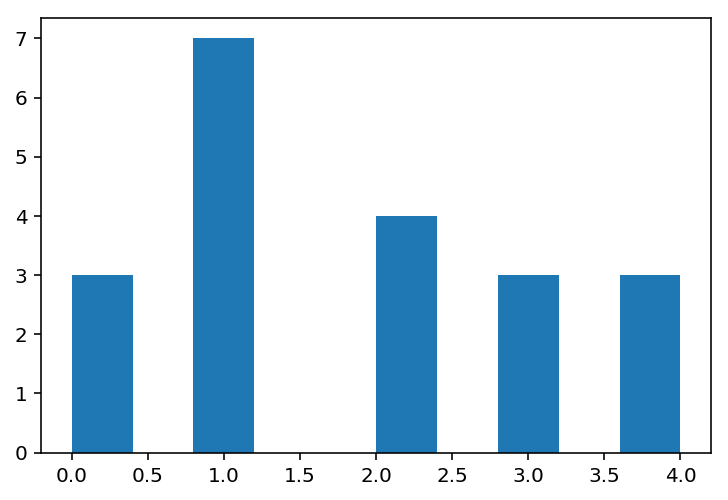

In [67]:
hist(Y[0])

## Barabasi-Albert (BA) Model
This model uses "Preferential Attachment" or "rich gets richer" to grow the graph. 

In [ ]:
n_nodes = 20
p = 2./n_nodes # density of edges (1=fully connected)

histories = {}

for n_samples in int0(logspace(log10(5e1), log10(2e3), 6))[::-1]:
    print ('%d Samples\n' % n_samples)
    histories[n_samples] = {}
    X = make_BA_dataset(n_samples, n_nodes, m = 2)
    Y = X.sum(-1, keepdims=1)
    h = ones_like(Y)
    #for units in int0(linspace((.25*n_nodes), (1.75*n_nodes), 9)):
    #    print(units)
    inputs = [Input(shape=X.shape[1:]),Input(shape= h.shape[1:]) ]

    gc = GCN(1)(inputs)
    # gc = GCN(1)(gc)

    model_GCN = Model(inputs = inputs, outputs = gc[1])

    model_GCN.compile(loss='mse', optimizer='adam')
#     model_GCN.summary()
    
    ephist_GCN = EpochHistory_1(verbosity=20)
    history = model_GCN.fit([X,h],[Y], validation_split=0.2, epochs= (2000*200)//n_samples, callbacks=[ephist_GCN], verbose=0)
    histories[n_samples] = history.history
        
#         for k in ['loss', 'val_loss']:
#             plot(ephist.history[k], label = k)
#         legend()
#         yscale('log')
#         xscale('log')
#         show()
        
        

In [520]:
# histories_DA

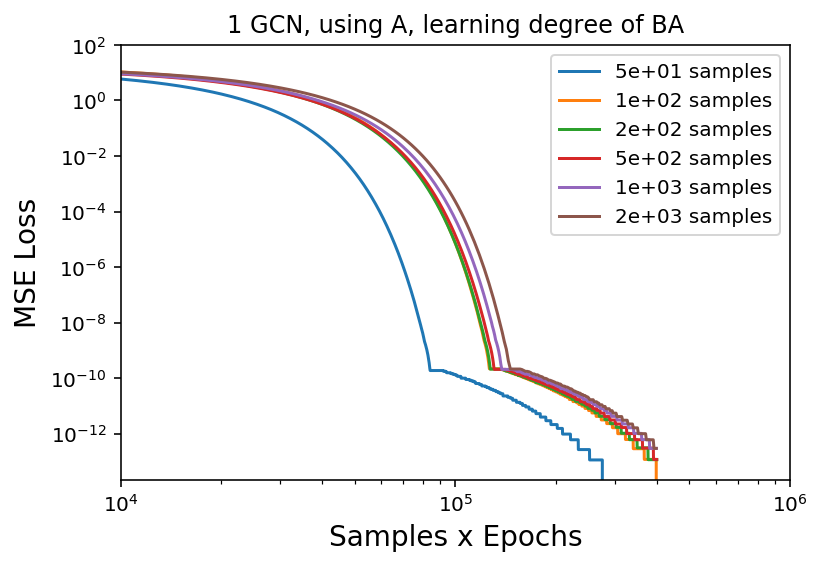

In [71]:
for k in sorted(histories):
    for s in ['val_loss']:
        y = histories[k][s]
        plot(arange(len(y))*k,y, label = '%.1g samples' %k)

title('1 GCN, using A, learning degree of BA')
legend()
yscale('log')
xscale('log')

ylabel('MSE Loss', size = 14)
xlim(1e4,1e6)
xlabel('Samples x Epochs', size = 14)
#     show()

savefig('../figs/expressivity/gcn-1-BA-N%d-var-samples.pdf' %(n_nodes))
savefig('../figs/expressivity/gcn-1-BA-N%d-var-samples.png' %(n_nodes), dpi = 300)

### BA with $D^{-1}A$

In [72]:
Y.shape

(49, 20, 1)

In [92]:

degs_inv = array([diag(1.*(i[:,0]!=0) /(maximum(i[:,0],1e-4))) for i in Y])

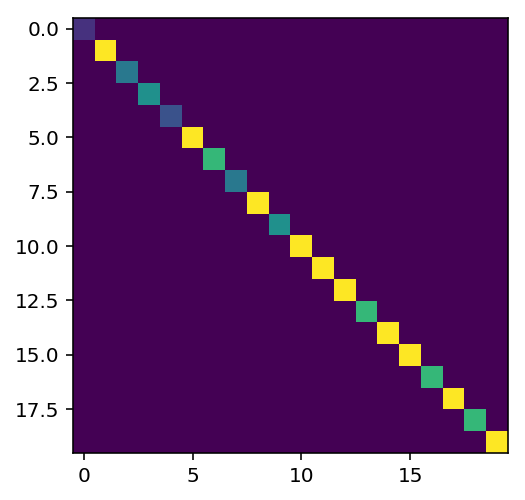

In [93]:
imshow(degs[0])

In [521]:
DA = array([d.dot(a) for d,a in zip(degs_inv,X)])

In [522]:
DA.shape, X.shape

((500, 20, 20), (500, 20, 20))

In [524]:
(max_samples*min_epoch)//n_samples

200.0

In [ ]:
n_nodes = 20
p = 2./n_nodes # density of edges (1=fully connected)

histories_DA = {}
max_samples = 2e3
min_epoch = 200

for n_samples in int0(logspace(log10(5e1), log10(max_samples), 6))[::-1]:
    print ('%d Samples\n' % n_samples)
    histories[n_samples] = {}
    X = make_BA_dataset(n_samples, n_nodes, m = 2)
    Y = X.sum(-1, keepdims=1)
    degs_inv = array([diag(1.*(i[:,0]!=0) /(maximum(i[:,0],1e-4))) for i in Y])
    DA = array([d.dot(a) for d,a in zip(degs_inv, X) ]) 
    h = ones_like(Y)
    #for units in int0(linspace((.25*n_nodes), (1.75*n_nodes), 9)):
    #    print(units)
    inputs = [Input(shape=DA.shape[1:]),Input(shape= h.shape[1:]) ]

    gc = GCN(1)(inputs)
    # gc = GCN(1)(gc)

    model_GCN = Model(inputs = inputs, outputs = gc[1])

    model_GCN.compile(loss='mse', optimizer='adam')
#     model_GCN.summary()
    
    ephist_GCN = EpochHistory_1(verbosity=20)
    history = model_GCN.fit([DA,h],[Y], validation_split=0.2, epochs= int((max_samples*min_epoch)//n_samples), 
                            callbacks=[ephist_GCN], verbose=0)
    histories_DA[n_samples] = history.history
        
        

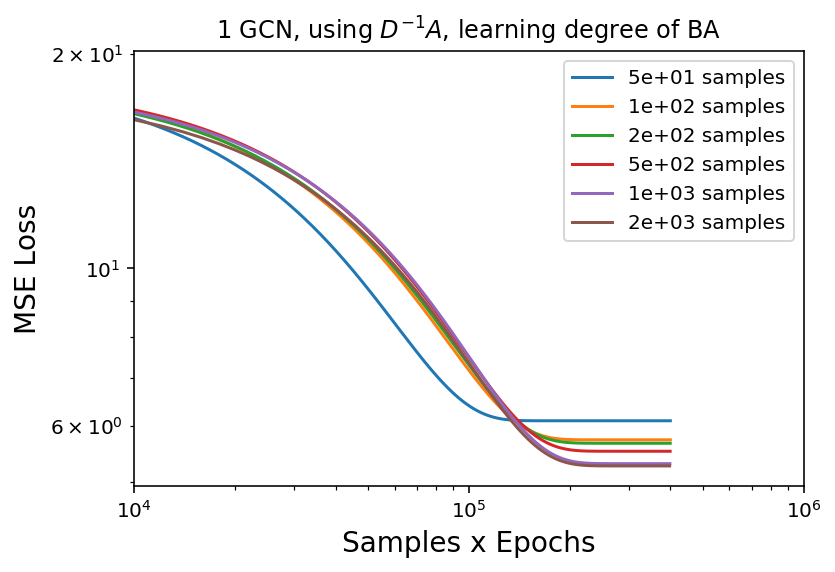

In [532]:
for k in sorted(histories):
    for s in ['val_loss']:
        y = histories_DA[k][s]
        plot(arange(len(y))*k,y, label = '%.1g samples' %k)

title(r'1 GCN, using $D^{-1}A$, learning degree of BA')
legend()
yscale('log')
xscale('log')

ylabel('MSE Loss', size = 14)
xlim(1e4,1e6)
xlabel('Samples x Epochs', size = 14)
#     show()

savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.pdf' %(n_nodes))
savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.png' %(n_nodes), dpi = 300)

# Conclusion

A GCN with the right Propagation Rule (PR) can learn the degree with O(1) parameters, even on very small datasets. 
But a GCN with the wrong PR cannot learn the degree for any number of samples. 

# Work on hybrid model taking both A and $D^{-1}A$ 

In [ ]:
# we can take the output of two networks and weight them with a single pair of weights

# can we also calculate degrees on the fly? 


In [106]:
n_nodes = 20
n_samples = int(5e2)

X = make_BA_dataset(n_samples, n_nodes, m = 2)
Y = X.sum(-1, keepdims=1)
degs_inv = array([diag(1.*(i[:,0]!=0) /(maximum(i[:,0],1e-4))) for i in Y])
DA = array([d.dot(a) for d,a in zip(X,degs_inv) ]) 
h = ones_like(Y)

In [103]:
from keras.layers import Concatenate #, concatenate

In [107]:
inputs = [Input(shape=X.shape[1:]),Input(shape=X.shape[1:]),Input(shape= h.shape[1:]) ]

gc_A = GCN(1)([inputs[0],inputs[-1]])
gc_DA = GCN(1)(inputs[1:])

c1 = Concatenate()([gc_A[1],gc_DA[1]])
d1 = Dense(1)(c1)

model_1 = Model(inputs = inputs, outputs = d1)

model_1.compile(loss='mse', optimizer='adam')
model_1.summary()

build: [(None, 20, 20), (None, 20, 1)]
call:
comp out [(None, 20, 20), (None, 20, 1)]
build: [(None, 20, 20), (None, 20, 1)]
call:
comp out [(None, 20, 20), (None, 20, 1)]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_79 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
input_81 (InputLayer)           (None, 20, 1)        0                                            
__________________________________________________________________________________________________
input_80 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
gcn_42 (GCN)                    [(No

In [ ]:
ephist_1 = EpochHistory_1(verbosity=20)

In [114]:

history = model_1.fit([X,DA,h],[Y], validation_split=0.2, epochs= 400, 
                        callbacks=[ephist_1], verbose=0)

Ep: 0	loss: 5.205e-06	val_loss: 5.214e-06
Ep: 20	loss: 1.92e-06	val_loss: 1.924e-06
Ep: 40	loss: 6.164e-07	val_loss: 6.165e-07
Ep: 60	loss: 1.679e-07	val_loss: 1.663e-07
Ep: 80	loss: 3.812e-08	val_loss: 3.751e-08
Ep: 100	loss: 6.987e-09	val_loss: 6.81e-09
Ep: 120	loss: 9.985e-10	val_loss: 9.692e-10
Ep: 140	loss: 1.115e-10	val_loss: 1.056e-10
Ep: 160	loss: 8.625e-12	val_loss: 7.952e-12
Ep: 180	loss: 5.728e-13	val_loss: 4.924e-13
Ep: 200	loss: 1.822e-13	val_loss: 4.359e-13
Ep: 220	loss: 1.694e-14	val_loss: 1.734e-14
Ep: 240	loss: 1.638e-14	val_loss: 2.547e-14
Ep: 260	loss: 1.609e-14	val_loss: 1.734e-14
Ep: 280	loss: 1.64e-14	val_loss: 2.558e-14
Ep: 300	loss: 1.727e-14	val_loss: 1.725e-14
Ep: 320	loss: 1.744e-14	val_loss: 1.725e-14
Ep: 340	loss: 1.755e-14	val_loss: 1.734e-14
Ep: 360	loss: 1.66e-14	val_loss: 2.575e-14
Ep: 380	loss: 1.659e-14	val_loss: 1.734e-14


Text(0, 0.5, 'MSE Loss')

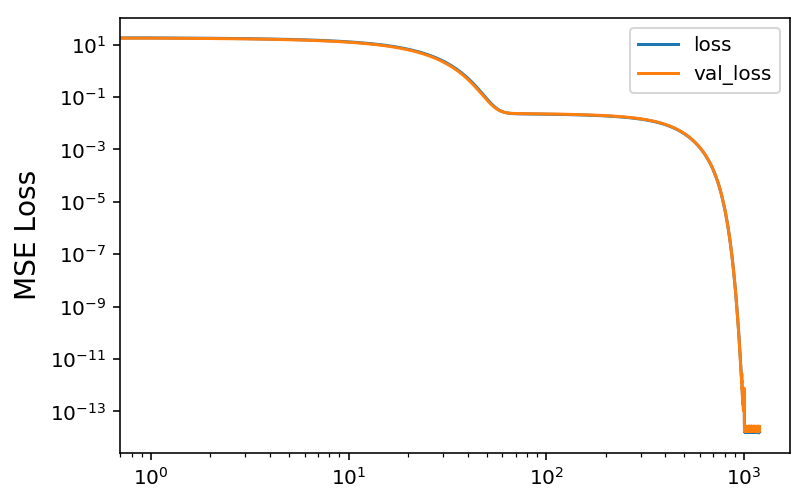

In [124]:
for s in ['loss','val_loss']:
    y = ephist_1.history[s]
    plot(arange(len(y)),y, label = s)

# title(r'1 GCN, using $D^{-1}A$, learning degree of BA')
legend()
yscale('log')
xscale('log')

ylabel('MSE Loss', size = 14)
# xlim(1e4,1e6)
# xlabel('Samples x Epochs', size = 14)
#     show()

# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.pdf' %(n_nodes))
# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.png' %(n_nodes), dpi = 300)

In [127]:
model_1.optimizer.lr.eval()

0.001

In [117]:
model_1.layers

In [121]:
l = model_1.layers[-1]
g1,g2 = model_1.layers[-4:-2]
g1,g2,l

(<__main__.GCN at 0x7f776161ab38>,
 <keras.layers.core.Dense at 0x7f776161afd0>)

In [119]:
w,b = l.get_weights()

In [120]:
w,b

(array([[-1.6540709],
        [ 0.9928133]], dtype=float32), array([1.2034171e-07], dtype=float32))

In [123]:
g1.get_weights(), g2.get_weights()

([array([[-0.60456896]], dtype=float32)],
 [array([[3.036748e-07]], dtype=float32)])

In [ ]:
keras.layers.Add()

In [ ]:


# sess = tf.InteractiveSession()
# K.set_session(sess)

class GCN(Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        super(GCN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build:',input_shape)
        A_shape, h_shape = input_shape
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(h_shape[-1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        super(GCN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        print('call:')
        A,h = inputs
        output = K.dot(K.batch_dot(A,h ), self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return [A, output]
        
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        A_shape, h_shape = input_shape
        return [A_shape, tuple(h_shape[:-1])+(self.kernel.shape.as_list()[-1],)]

In [ ]:
class GCN(Layer):

    def __init__(self, units, **kwargs):
        self.units = units
        super(GCN, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build:',input_shape)
        A_shape, h_shape = input_shape
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(h_shape[-1], self.units),
                                      initializer='uniform',
                                      trainable=True)
        super(GCN, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        print('call:')
        A,h = inputs
        output = K.dot(K.batch_dot(A,h ), self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return [A, output]
        
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        A_shape, h_shape = input_shape
        return [A_shape, tuple(h_shape[:-1])+(self.kernel.shape.as_list()[-1],)]

In [596]:
class GCN2(Dense):
    def __init__(self, **kwargs):
        """ Same arguments as dense, except that it is called with [M,h] as input """
        super(GCN2, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build:',input_shape)
        M_shape, h_shape = input_shape
        super(GCN2, self).build(h_shape)  # Be sure to call this at the end
    
    def call(self, inputs):
        M,h = inputs
        Mh = K.batch_dot(M,h)
        return super(GCN2, self).call(Mh)
    
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        M_shape, h_shape = input_shape
        return [M_shape, super(GCN2, self).compute_output_shape(h_shape)]

In [644]:
# @keras.layers.Lambda
def GCN3(inputs,units, **kwargs):
    """GCN: M: graph, h: node attributes; Use like dense layer. """
    M,h = inputs 
    Mh = K.batch_dot(M,h)
    return Dense(units, **kwargs)(Mh)

In [647]:
g2 = GCN3(inputs,units = 3, activation='tanh')

In [31]:
class GCN3(Dense):
    def __init__(self, **kwargs):
        """ Same arguments as dense, except that it is called with [M,h] as input """
        self.kwargs = kwargs
        super(GCN3, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        print('build:',input_shape)
        M_shape, h_shape = input_shape
        super(GCN3, self).build(h_shape)  # Be sure to call this at the end
    
    def call(self, inputs):
        M,h = inputs
        Mh = K.batch_dot(M,h)
        return super(GCN3, self).call(Mh)
    
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        M_shape, h_shape = input_shape
        return [M_shape, super(GCN2, self).compute_output_shape(h_shape)]

In [279]:
class Graph_Operators(Layer):
    eps = 1e-8 # to avoid nan for inverse degree. works for float32
    def __init__(self, **kwargs):
        """Takes a batch of adjacency matrices and outputs [A, D^{-1}A, D^{-1/2}AD^{-1/2}]"""
        super(Graph_Operators, self).__init__(**kwargs)
        
    def call(self, A):
        D = K.tf.reduce_sum(A, axis = -1, keepdims = True)
        # To make D^{-1}A, we can simply multiply 1/D from the left, but we have to add a new axis 
        Dinv = K.tf.to_float(D > 0) / (D + self.eps)
        DA = Dinv * A 
        # for D^{-1/2}AD^{-1/2}, the following pointwise operation works
        d2 = K.tf.sqrt(Dinv) # D^{-1/2}
        DAD =  d2 * A * d2[:,newaxis,:,0] 
        return [A,DA,DAD]
        
    def compute_output_shape(self, input_shape):
        return [input_shape]*3

In [276]:
class GCN4(Layer):
    def __init__(self,units,activation=None, **kwargs):
        """ Same arguments as dense, except that it is called with [M,h] as input """
        self.kwargs = kwargs
        self.dense = Dense(units, activation = activation, **kwargs)
        super(GCN4, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        M_shape, h_shape = input_shape
        
        #super(GCN3, self).build(h_shape)  # Be sure to call this at the end
    
    def call(self, inputs):
        M,h = inputs
        Mh = K.batch_dot(M,h)
        return self.dense(Mh)
    
    def compute_output_shape(self, input_shape):
        print('comp out',input_shape)
        M_shape, h_shape = input_shape
        return [M_shape, self.dense.compute_output_shape(h_shape)]

In [24]:
n_nodes = 20
n_samples = 500
X = make_BA_dataset(n_samples, n_nodes, m = 2)
Y = X.sum(-1, keepdims=1)
degs_inv = array([diag(1.*(i[:,0]!=0) /(maximum(i[:,0],1e-4))) for i in Y])
DA = array([d.dot(a) for d,a in zip(degs_inv, X) ]) 
h = ones_like(Y)

In [27]:

inputs = [Input(shape=X.shape[1:]), Input(shape= h.shape[1:]) ]

# 1) get the graph operators

gr_ops = Graph_Operators()(inputs[0])

In [106]:
from keras.layers import InputSpec

class GCN3(Dense):
    def __init__(self, **kwargs):
        """ Same arguments as dense, except that it is called with [M,h] as input """
        self.kwargs = kwargs
        super(GCN3, self).__init__(**kwargs)
        # gotta redefine input_spec b/c we have two inputs whiule Dense has one
        self.input_spec = [InputSpec(min_ndim=2),InputSpec(min_ndim=2)]
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        M_shape, h_shape = input_shape
        super(GCN3, self).build(h_shape)  # Be sure to call this at the end
        # Dense.build redefines input_spec; change it to avoid error when calling with two inputs [M,h]
        self.input_spec = [InputSpec(min_ndim=2),self.input_spec]
    
    def call(self, inputs):
        M,h = inputs
        Mh = K.batch_dot(M,h)
        return super(GCN3, self).call(Mh)
    
    def compute_output_shape(self, input_shape):
        M_shape, h_shape = input_shape
        return super(GCN3, self).compute_output_shape(h_shape)
#         return [M_shape, super(GCN3, self).compute_output_shape(h_shape)]

In [90]:
gr_ops

[<tf.Tensor 'graph__operators_2/Identity:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_2/mul:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_2/mul_2:0' shape=(?, 20, 20) dtype=float32>]

In [107]:
# Now we have properly working GCN that uses Dense
# Let's first apply it to the gr_ops and the uniform input h

g3 = GCN3(units = 3, activation = 'tanh')
g3_ = g3([gr_ops[1], inputs[1]])


In [108]:
g3.compute_output_shape([(None, 20, 20), (None, 20, 1)])

(None, 20, 3)

In [110]:
g3_

<tf.Tensor 'gc_n3_17/Tanh:0' shape=(?, 20, 3) dtype=float32>

In [111]:

g31 = GCN3(units = 4, activation = 'tanh')([gr_ops[1], g3_])

In [112]:
gs = [GCN3(units = 3, activation = 'tanh')([g, inputs[1]]) for g in gr_ops ]

## Connecting the outputs to the next layer
How do we want to combine the outputs of these three GCN? 
Should we just concat them and pass them through a dense layer to have all combinations? What is the alternative? 


In [118]:
# Is we concat these, the channels will add up.... do we wan that? 
con = Concatenate()(gs)

In [123]:

d1 = Dense(len(gr_ops))
d1_ = d1(con)

In [126]:
d1.input_shape, d1.output_shape

((None, 20, 9), (None, 20, 3))

# Check if single works as expected for learning degree

In [127]:
gs

[<tf.Tensor 'gc_n3_19/Tanh:0' shape=(?, 20, 3) dtype=float32>,
 <tf.Tensor 'gc_n3_20/Tanh:0' shape=(?, 20, 3) dtype=float32>,
 <tf.Tensor 'gc_n3_21/Tanh:0' shape=(?, 20, 3) dtype=float32>]

In [157]:
n_nodes = 20
n_samples = 2000
X = make_BA_dataset(n_samples, n_nodes, m = 2)
Y = X.sum(-1, keepdims=1)
degs_inv = array([diag(1.*(i[:,0]!=0) /(maximum(i[:,0],1e-4))) for i in Y])
DA = array([d.dot(a) for d,a in zip(degs_inv, X) ]) 
h = ones_like(Y)

In [ ]:
GCN_List = [GCN3(units = 1, activation = 'linear',use_bias=False, 
           name = nam)([g, inputs[1]]) for g,nam in zip(gr_ops,['A','DA', 'DAD']) ]

In [280]:
inputs = [Input(shape=X.shape[1:]), Input(shape= h.shape[1:]) ]

# 1) get the graph operators
gr_ops = Graph_Operators()(inputs[0])
# 2) make the GCN3 
gs = [GCN3(units = 1, activation = 'linear',use_bias=False, 
           name = nam)([g, inputs[1]]) for g,nam in zip(gr_ops,['A','DA', 'DAD']) ]
# Dense(use_bias=False)
# # 3) Concat outputs
# con = Concatenate()(gs)

# 4) Add layer adds the tensors, so output shape same as single one
ad1 = layers.Add()(gs[:])

model = Model(inputs = inputs, outputs = ad1 )

In [281]:
gr_ops

[<tf.Tensor 'graph__operators_18/Identity:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_18/mul:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_18/mul_2:0' shape=(?, 20, 20) dtype=float32>]

In [282]:
model.compile(loss='mse', optimizer='adam')

In [283]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_34 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
graph__operators_18 (Graph_Oper [(None, 20, 20), (No 0           input_34[0][0]                   
__________________________________________________________________________________________________
input_35 (InputLayer)           (None, 20, 1)        0                                            
__________________________________________________________________________________________________
A (GCN3)                        (None, 20, 1)        1           graph__operators_18[0][0]        
                                                                 input_35[0][0]                   
__________

In [208]:
ephist_1 = EpochHistory_1(verbosity=20)

In [210]:

history = model.fit([X,h],[Y], validation_split=0.2, epochs= 200, 
                        callbacks=[ephist_1], verbose=0)

Ep: 0	loss: 8.18e-06	val_loss: 7.251e-06
Ep: 20	loss: 4.941e-08	val_loss: 4.102e-08
Ep: 40	loss: 9.689e-12	val_loss: 6.869e-12
Ep: 60	loss: 1.156e-13	val_loss: 6.953e-14
Ep: 80	loss: 4.894e-14	val_loss: 4.737e-14
Ep: 100	loss: 1.11e-19	val_loss: 0
Ep: 120	loss: 0	val_loss: 0
Ep: 140	loss: 0	val_loss: 0
Ep: 160	loss: 0	val_loss: 0
Ep: 180	loss: 0	val_loss: 0


Text(0, 0.5, 'MSE Loss')

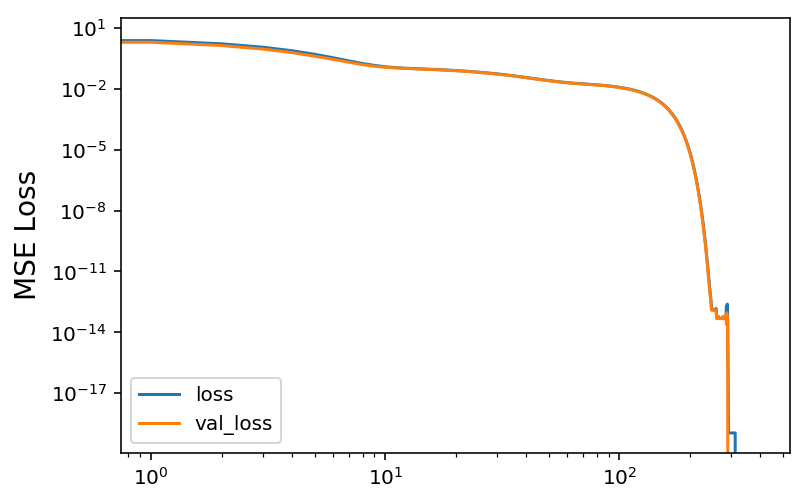

In [211]:
for s in ['loss','val_loss']:
    y = ephist_1.history[s]
    plot(arange(len(y)),y, label = s)

# title(r'1 GCN, using $D^{-1}A$, learning degree of BA')
legend()
yscale('log')
xscale('log')

ylabel('MSE Loss', size = 14)
# xlim(1e4,1e6)
# xlabel('Samples x Epochs', size = 14)
#     show()

# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.pdf' %(n_nodes))
# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.png' %(n_nodes), dpi = 300)

In [212]:
model.get_weights()

[array([[1.]], dtype=float32),
 array([[-1.5126165e-08]], dtype=float32),
 array([[-5.1511087e-08]], dtype=float32)]

In [201]:
model.layers

In [202]:
model.layers[1].output_shape

[(None, 20, 20), (None, 20, 20), (None, 20, 20)]

In [203]:
model.layers[-2].get_weights()

[array([[5.7911525]], dtype=float32)]

In [204]:
model.layers[-3].get_weights()

[array([[-1.5630121]], dtype=float32)]

## Change Graph_Operators to return names and identity matrix $[I,A,DA,DAD]$


In [342]:
from collections import OrderedDict

class Graph_Operators_1(Layer):
    eps = 1e-8 # to avoid nan for inverse degree. works for float32
    def __init__(self, **kwargs):
        """Takes a batch of adjacency matrices and outputs [A, D^{-1}A, D^{-1/2}AD^{-1/2}]"""
        super(Graph_Operators_1, self).__init__(**kwargs)
        
    def call(self, A):
        D = K.tf.reduce_sum(A, axis = -1, keepdims = True)
        # To make D^{-1}A, we can simply multiply 1/D from the left, but we have to add a new axis 
        Dinv = K.tf.to_float(D > 0) / (D + self.eps)
        DA = Dinv * A 
        # for D^{-1/2}AD^{-1/2}, the following pointwise operation works
        d2 = K.tf.sqrt(Dinv) # D^{-1/2}
        DAD =  d2 * A * d2[:,newaxis,:,0]
        
        #out = OrderedDict([('A', A), ('DA', DA), ('DAD', DAD)])
        out = [A,DA,DAD]
        self.op_names = ['A', 'DA', 'DAD']
        self.out_len = len(out)
        return out    
                
    def compute_output_shape(self, input_shape):
        return [input_shape]*self.out_len
    
    
def GCN_List(gr_ops, inputs, units=1, activation = 'linear',use_bias=False, names = None,**kwargs):
    """ gr_ops: output of Graph_Operators
    kwargs passed to GCN
    names : used to name operators
    """
    if names == None:
        names = ['gcn_%d'%i for i in range(len(gr_ops))]
    return [GCN3(units = units, activation = activation,use_bias=use_bias, 
               name = nam, **kwargs)([g, inp]) for g, nam, inp in zip(gr_ops,names, inputs) ]



In [353]:
inputs = [Input(shape=X.shape[1:]), Input(shape= h.shape[1:]) ]

# 1) get the graph operators
gr_ops = Graph_Operators()(inputs[0])

# 2) make the GCN3 
gs = GCN_List(gr_ops, len(gr_ops)*[inputs[1]], names=['A', 'DA', 'DAD'])



In [354]:
gr_ops

[<tf.Tensor 'graph__operators_32/Identity:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_32/mul:0' shape=(?, 20, 20) dtype=float32>,
 <tf.Tensor 'graph__operators_32/mul_2:0' shape=(?, 20, 20) dtype=float32>]

In [355]:
gs

[<tf.Tensor 'A_14/Reshape_2:0' shape=(?, 20, 1) dtype=float32>,
 <tf.Tensor 'DA_11/Reshape_2:0' shape=(?, 20, 1) dtype=float32>,
 <tf.Tensor 'DAD_11/Reshape_2:0' shape=(?, 20, 1) dtype=float32>]

In [356]:
model = Model(inputs = inputs, outputs = gs[2] )

In [357]:

# # 3) Concat outputs
# con = Concatenate()(gs)

# 4) Add layer adds the tensors, so output shape same as single one
ad1 = layers.Add()(gs[:])

model = Model(inputs = inputs, outputs = ad1 )

In [358]:
model.compile(loss='mse', optimizer='adam')

In [359]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_78 (InputLayer)           (None, 20, 20)       0                                            
__________________________________________________________________________________________________
graph__operators_32 (Graph_Oper [(None, 20, 20), (No 0           input_78[0][0]                   
__________________________________________________________________________________________________
input_79 (InputLayer)           (None, 20, 1)        0                                            
__________________________________________________________________________________________________
A (GCN3)                        (None, 20, 1)        1           graph__operators_32[0][0]        
                                                                 input_79[0][0]                   
__________

In [360]:
ephist_1 = EpochHistory_1(verbosity=20)

In [362]:

history = model.fit([X,h],[Y], validation_split=0.2, epochs= 200, 
                        callbacks=[ephist_1], verbose=0)

Ep: 0	loss: 0.05326	val_loss: 0.05196
Ep: 20	loss: 0.03803	val_loss: 0.03696
Ep: 40	loss: 0.02263	val_loss: 0.02187
Ep: 60	loss: 0.01037	val_loss: 0.00994
Ep: 80	loss: 0.003222	val_loss: 0.00305
Ep: 100	loss: 0.0005305	val_loss: 0.0004932
Ep: 120	loss: 2.917e-05	val_loss: 2.598e-05
Ep: 140	loss: 2.402e-07	val_loss: 2.007e-07
Ep: 160	loss: 7.745e-11	val_loss: 5.778e-11
Ep: 180	loss: 5.323e-14	val_loss: 5.296e-14


Text(0, 0.5, 'MSE Loss')

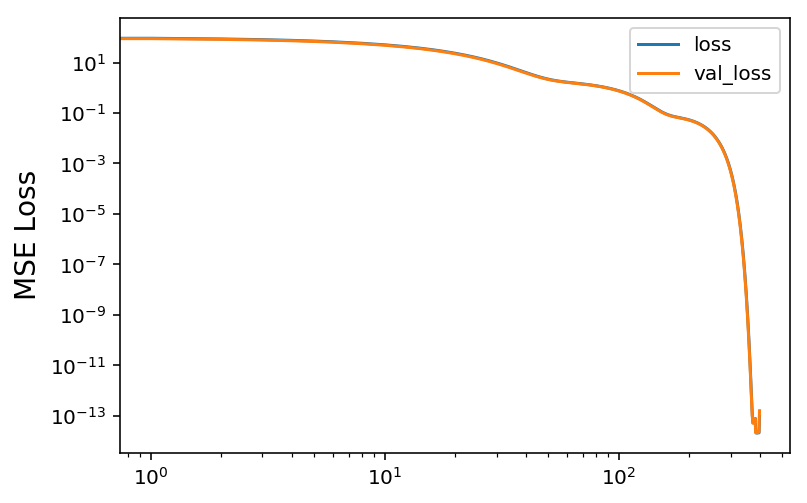

In [363]:
for s in ['loss','val_loss']:
    y = ephist_1.history[s]
    plot(arange(len(y)),y, label = s)

# title(r'1 GCN, using $D^{-1}A$, learning degree of BA')
legend()
yscale('log')
xscale('log')

ylabel('MSE Loss', size = 14)
# xlim(1e4,1e6)
# xlabel('Samples x Epochs', size = 14)
#     show()

# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.pdf' %(n_nodes))
# savefig('../figs/expressivity/gcn-DA-BA-N%d-var-samples.png' %(n_nodes), dpi = 300)

In [364]:
model.get_weights()

[array([[1.]], dtype=float32),
 array([[-4.5007837e-09]], dtype=float32),
 array([[3.0664467e-07]], dtype=float32)]

In [365]:
model.layers